## LADOT nearest neighbor

7 trips, 2 dates!

* Assemble the data that we need 
   * stop_time grain from schedule side
   * trip grain from vp side
   * use Cal-ITP warehouse tables -> switch to partridge later
* Grab what we need from [data-analyses repo](https://github.com/cal-itp/data-analyses/tree/main/rt_segment_speeds/scripts). Each of these are individual stages that we save out, but let's put it together here in a notebook

### Stage of data processing
1. stop times 
2. vehicle positions

### Stages of getting speeds

3. [nearest neighbor](https://github.com/cal-itp/data-analyses/blob/main/rt_segment_speeds/scripts/nearest_vp_to_stop.py)
4. [interpolate stop arrivals](https://github.com/cal-itp/data-analyses/blob/main/rt_segment_speeds/scripts/interpolate_stop_arrival.py) (this becomes a useful output too, to have a corresponding RT stop times table.)
5. [speeds](https://github.com/cal-itp/data-analyses/blob/main/rt_segment_speeds/scripts/stop_arrivals_to_speed.py) - the output we most obviously need.
6. [averaging speeds by segment](https://github.com/cal-itp/data-analyses/blob/main/rt_segment_speeds/scripts/average_segment_speeds.py)

In [1]:
import branca 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd

import create_table
import utils
import neighbor
import compare_utils

In [2]:
ladot_key = "cc53a0dbf5df90e3009b9cb5d89d80ba"
trips_to_use = [
    "183-07rmbur",
    "30--wPRGN1uEEG",
    "30-_6WXotLOIF7fc",
    "47-3pbila5j7",
]

loopy_trips_to_use = [
    "183-04u26szx9",
    "30-15t6vxs", 
    "30-0SpZx5QGbqM"
]

trip_filter = [[
    ("schedule_gtfs_dataset_key", "==", ladot_key),
    ("trip_id", "in", trips_to_use + loopy_trips_to_use)
]]

gdf = create_table.stop_times_with_vp_table(
    filters = trip_filter
)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in cardinal_definition_rules (vectorized)
  outputs = ufunc(*inputs)
/opt/conda/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [3]:
stops_vp_map = gdf[["stop_sequence", "stop_geometry"]].explore(
    "stop_sequence",
    categorical=True, legend=False,
    tiles = "CartoDB Positron",
    name = "stops"
)

gdf[["trip_instance_key", "vp_geometry"]
].drop_duplicates().set_geometry("vp_geometry").explore(
    "trip_instance_key",
    m=stops_vp_map, categorical=True,
    name="vp", 
)

gdf[["shape_id", "shape_geometry"]
].drop_duplicates().set_geometry("shape_geometry").explore(
    "shape_id",
    m=stops_vp_map, categorical=True,
    name="shape", 
)
folium.LayerControl().add_to(stops_vp_map)
stops_vp_map

In [4]:
trip_cols = ["schedule_gtfs_dataset_key", "trip_instance_key"]

In [5]:
def nearest_neighbor_and_interpolate(gdf):
    vp_before, vp_after, vp_before_meters, vp_after_meters = np.vectorize(
        neighbor.two_nearest_neighbor_near_stop
    )(
        gdf.vp_primary_direction, 
        gdf.vp_geometry, 
        gdf.vp_idx,
        gdf.stop_geometry,
        gdf.stop_opposite_direction,
        gdf.shape_geometry,
        gdf.stop_meters
    )
    
    gdf = gdf.assign(
        prior_vp_idx = vp_before,
        subseq_vp_idx = vp_after,
        prior_vp_meters = vp_before_meters, 
        subseq_vp_meters = vp_after_meters
    )
    
    start_time_series = []
    end_time_series = []

    for row in gdf.itertuples():
        start_time, end_time = neighbor.grab_vp_timestamp(
            getattr(row, "prior_vp_idx"),
            getattr(row, "subseq_vp_idx"),
            getattr(row, "vp_idx"),
            getattr(row, "location_timestamp_local"),
        )

        start_time_series.append(start_time)
        end_time_series.append(end_time)
    
    gdf = gdf.assign(
        start_local_timestamp = start_time_series,
        end_local_timestamp = end_time_series
    )
    
    interpolated_arrival_series = []

    for row in gdf.itertuples():
        if (getattr(row, "prior_vp_idx") == -1) or (getattr(row, "subseq_vp_idx") == -1):
            arrival_time = np.nan
        else:
            arrival_time = neighbor.interpolate_stop_arrival_time(
                getattr(row, "stop_meters"),
                [getattr(row, "prior_vp_meters"), getattr(row, "subseq_vp_meters")],
                [getattr(row, "start_local_timestamp"), getattr(row, "end_local_timestamp")]
            )

        interpolated_arrival_series.append(arrival_time)
        
    gdf["arrival_time"] = interpolated_arrival_series
    
    return gdf

In [6]:
def enforce_monotonicity_calculate_speeds(gdf):
    drop_cols = [
        "stop_opposite_direction",
        "vp_geometry", "vp_idx",
        'location_timestamp_local', 'vp_primary_direction', 
        'shape_geometry',
        'prior_vp_idx', 'subseq_vp_idx', 
        'prior_vp_meters', 'subseq_vp_meters', 
        'start_local_timestamp', 'end_local_timestamp'
    ]
    
    trip_stop_cols = ["trip_instance_key", "stop_sequence"]

    gdf2 = neighbor.enforce_monotonicity_and_interpolate_across_stops(
        gdf, trip_stop_cols).drop(columns = drop_cols)
    
    speeds = neighbor.calculate_speed_from_stop_arrivals(
        gdf2,
        trip_cols = ["trip_instance_key"],
        trip_stop_cols = ["trip_instance_key", "stop_sequence"]
    )
    
    segments = gpd.read_parquet(
        f"{PARTRIDGE_FOLDER}LADOT/segments.parquet",
    )
    
    speed_gdf = pd.merge(
        segments.rename(columns = {"geometry": "segment_geometry"}),
        speeds,
        on = ["trip_id", "stop_id1", "stop_id2"]
    )
    
    return speed_gdf

In [7]:
gdf2 = nearest_neighbor_and_interpolate(gdf)
speed_gdf = enforce_monotonicity_calculate_speeds(gdf2)

/opt/conda/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


### "Good Trips" Mapped

min speed: 3.1818066473818982, max speed: inf
total rows: 168
rows with invalid speeds: 26
rows with valid speeds: 142


<AxesSubplot:>

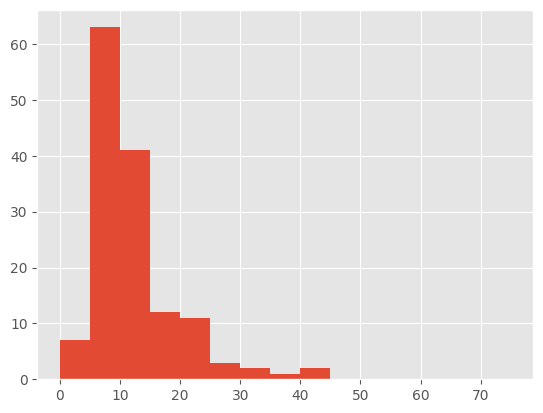

In [8]:
compare_utils.speed_stats(
    speed_gdf[speed_gdf.trip_id.isin(trips_to_use)]
)

In [9]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(trips_to_use)) & 
        (speed_gdf.service_date=="2024-10-16")
    ]
)

<AxesSubplot:>

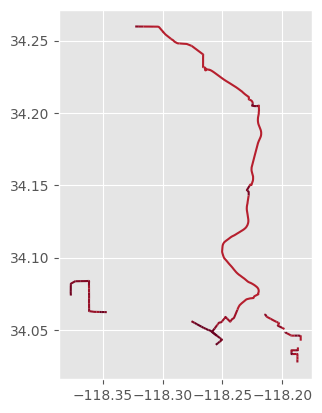

In [10]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(trips_to_use)) & 
        (speed_gdf.service_date=="2024-10-16")
    ], 
    static=True
)

In [11]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(trips_to_use)) & 
        (speed_gdf.service_date=="2024-11-13")
    ]
)

<AxesSubplot:>

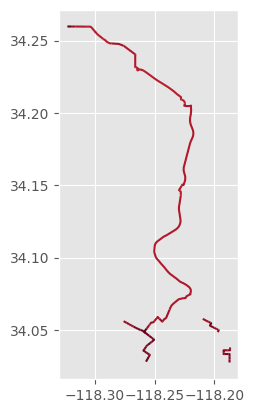

In [12]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(trips_to_use)) & 
        (speed_gdf.service_date=="2024-11-13")
    ], 
    static=True
)

### Loopy Trips Mapped

min speed: -12.662418843618914, max speed: inf
total rows: 182
rows with invalid speeds: 10
rows with valid speeds: 172


<AxesSubplot:>

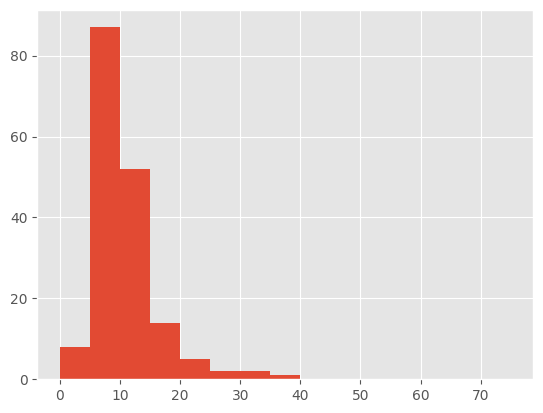

In [13]:
compare_utils.speed_stats(
    speed_gdf[speed_gdf.trip_id.isin(loopy_trips_to_use)]
)

In [14]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(loopy_trips_to_use)) & 
        (speed_gdf.service_date=="2024-10-16")
    ]
)

<AxesSubplot:>

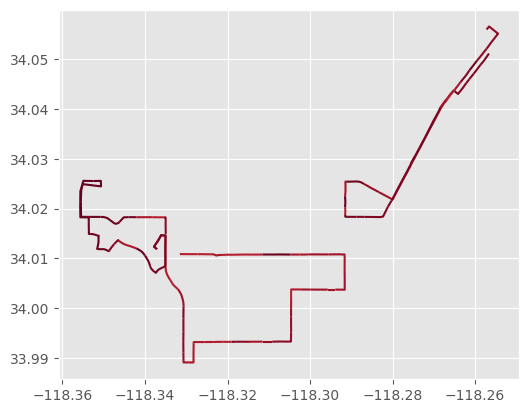

In [15]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(loopy_trips_to_use)) & 
        (speed_gdf.service_date=="2024-10-16")
    ], 
    static=True
)

In [16]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(loopy_trips_to_use)) & 
        (speed_gdf.service_date=="2024-11-13")
    ], 
)

<AxesSubplot:>

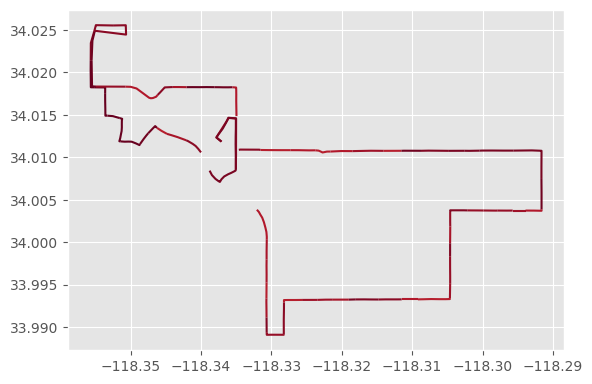

In [17]:
compare_utils.speed_map(
    speed_gdf[
        (speed_gdf.trip_id.isin(loopy_trips_to_use)) & 
        (speed_gdf.service_date=="2024-11-13")
    ], 
    static=True
)